# Dual-module Bayesian Neural Network

TODO: intro



In [1]:
# Install packages
#!pip install -q --upgrade tensorflow==2.0.0-beta0
!pip install -q --upgrade tf-nightly-gpu-2.0-preview
!pip install -q tfp-nightly
!pip install -q catboost
!pip install -q --pre vaex

     |████████████████████████████████| 370.7MB 82kB/s 
     |████████████████████████████████| 61kB 27.4MB/s 
     |████████████████████████████████| 3.2MB 39.9MB/s 
     |████████████████████████████████| 450kB 43.8MB/s 
     |████████████████████████████████| 1.1MB 3.4MB/s 
     |████████████████████████████████| 61.2MB 40.0MB/s 
     |████████████████████████████████| 1.7MB 5.1MB/s 
     |████████████████████████████████| 2.8MB 38.8MB/s 


In [0]:
# Packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import vaex

from sklearn.dummy import DummyRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow_probability.python.math import random_rademacher

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from catboost import CatBoostRegressor

# Settings
sns.set()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%config InlineBackend.figure_format = 'svg'
np.random.seed(111)
tf.random.set_seed(111)

## Data

TODO: explain, mention more eda in previous post

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Columns to load
dtypes = {'fare_amount':      'float32',
          'pickup_datetime':  'str', 
          'pickup_longitude': 'float32',
          'pickup_latitude':  'float32',
          'dropoff_longitude':'float32',
          'dropoff_latitude': 'float32'}

# Load data
#train = pd.read_csv('train.csv', # TODO
train = pd.read_csv('/content/gdrive/My Drive/DataScience/Data/train.zip', 
                    usecols=dtypes.keys(), 
                    dtype=dtypes,
                    nrows=200000)

# Convert pickup time column to datetime
train['pickup_datetime'] = train['pickup_datetime'].str.slice(0, 16)
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], 
                                          utc=True, 
                                          format='%Y-%m-%d %H:%M')

In [0]:
# Drop rows with empty values
train.dropna(inplace=True)

# Extract useful time information
train['min_of_day'] = (60*train['pickup_datetime'].dt.hour + 
                       train['pickup_datetime'].dt.minute)
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek
train['day_of_year'] = train['pickup_datetime'].dt.dayofyear
train['year'] = train['pickup_datetime'].dt.year

# Remove original datetime column
train.drop('pickup_datetime', axis=1, inplace=True)

# Ensure all columns are float32s
train = train.astype('float32')

# Function to remove rows outside range
def clip(df, a, b, col):
    for c in col:
        df = df[(df[c]>a) & (df[c]<b)]
    return df

# Remove outliers
train = clip(train, 1, 200, ['fare_amount'])
train = clip(train,  -75, -72.5,
             ['pickup_longitude', 'dropoff_longitude'])
train = clip(train, 40, 41.5,
             ['pickup_latitude', 'dropoff_latitude'])

# Make copy with untransformed data
train_orig = train.copy()

# Transform target column
train['fare_amount'] = np.log(np.log10(train['fare_amount']))

# Normalize data
train = (train - train.mean()) / train.std()

# Separate in- from dependent variables
x_taxi = train.drop('fare_amount', axis=1)
y_taxi = train['fare_amount']

TODO: print head and simple plots

## Baseline Models

In [0]:
# Make Mean Absolute Error scorer
mae_scorer = make_scorer(mean_absolute_error)

# Function to print cross-validated mean abs deviation
def cv_mae(regressor, x, y, cv=3, scorer=mae_scorer):
    scores = cross_val_score(regressor, 
                             x, y, cv=cv,
                             scoring=scorer)
    print('MAE:', scores.mean())

In [7]:
# MAE from predicting just the mean
cv_mae(DummyRegressor(), x_taxi, y_taxi)

MAE: 0.7927840153376261


In [8]:
# Distance between pickup and dropoff locations
dist = np.sqrt(
    np.power(x_taxi['pickup_longitude'] -
             x_taxi['dropoff_longitude'], 2) + 
    np.power(x_taxi['pickup_latitude'] - 
             x_taxi['dropoff_latitude'], 2))

# MAE from using just distance as predictor
cv_mae(IsotonicRegression(out_of_bounds='clip'), 
       dist, y_taxi)

MAE: 0.3694203396638234


TODO: let's also see how a gradient-boosted decision tree does.

In [0]:
# MAE using CatBoost
cv_mae(CatBoostRegressor(verbose=False, depth=9), x_taxi, y_taxi)

MAE: 0.30021984335733554


## Vanilla Neural Network

TODO: first will try just a normal neural net, but first need to set some settings which we'll use for the training of all neural nets (bayesian and non-bayesian)

In [0]:
# Batch size
BATCH_SIZE = 1024

# Number of training epochs
EPOCHS = 100

# Learning rate
L_RATE = 1e-3

# Proportion of samples to hold out
VAL_SPLIT = 0.2

TODO: then build a normal neural net 

TODO: diagram

In [0]:
# Multilayer dense neural network
D = x_taxi.shape[1]
model = Sequential([
    Dense(512, use_bias=False, input_shape=(D,)),
    BatchNormalization(),
    ReLU(),
    Dropout(0.1),
    Dense(128, use_bias=False),
    BatchNormalization(),
    ReLU(),
    Dropout(0.1),
    Dense(64, use_bias=False),
    BatchNormalization(),
    ReLU(),
    Dropout(0.1),
    Dense(1)
])

In [0]:
# Compile the model using MAE
model.compile(tf.keras.optimizers.Adam(lr=L_RATE),
              loss='mean_absolute_error')

In [12]:
# Stop training when we start to overfit
# Reduce learning rate if not improving
callbacks = [
    EarlyStopping(patience=20, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=10, min_delta=1e-4)
]

# Fit the model
history = model.fit(x_taxi, y_taxi,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=VAL_SPLIT,
                    callbacks=callbacks,
                    verbose=0)

W0710 04:00:24.902664 140228461934464 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:460: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


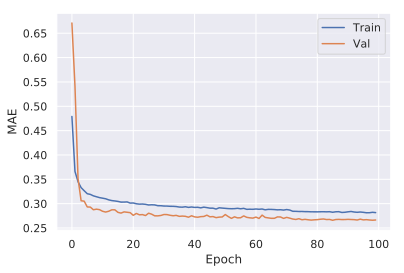

In [13]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

TODO: note that val loss is less than train loss, this is bc of the dropout

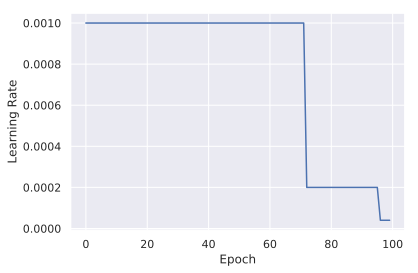

In [14]:
plt.plot(history.history['lr'])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.show()

## Simple Bayesian Neural Network

TODO: were gonna use TFP DenseFlipout layer but it doesn't fully support TF2.0 eager execution yet!  ie the kl loss was getting reset each batch


In [15]:
# Split data randomly into training + validation
tr_ind = np.random.choice([False, True],
                          size=x_taxi.shape[0],
                          p=[VAL_SPLIT, 1.0-VAL_SPLIT])
x_train = x_taxi[tr_ind].values
y_train = y_taxi[tr_ind].values
x_val = x_taxi[~tr_ind].values
y_val = y_taxi[~tr_ind].values
N_train = x_train.shape[0]
N_val = x_val.shape[0]

# Make y 2d
y_train = np.expand_dims(y_train, 1)
y_val = np.expand_dims(y_val, 1)

# Make a TensorFlow Dataset from training data
data_train = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(BATCH_SIZE)

# Make a TensorFlow Dataset from validation data
data_val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(N_val)

W0710 04:06:57.297900 140228461934464 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/data/util/random_seed.py:58: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


TODO: xavier initializer to initialize the weights (link etc)

In [0]:
# Xavier initializer
def xavier(shape):
    return tf.random.truncated_normal(
        shape, 
        mean=0.0,
        stddev=np.sqrt(2/sum(shape)))

TODO: simple version of a bayesian dense neural network layer. Takes one sample from the variational distributions per batch

In [0]:
class BayesianDenseLayer(tf.keras.Model):
    """TODO docs"""

    def __init__(self, d_in, d_out, name=None):
        super(BayesianDenseLayer, self).__init__(name=name)
        self.w_loc = tf.Variable(xavier([d_in, d_out]), name='w_loc')
        self.w_std = tf.Variable(xavier([d_in, d_out])-6.0, name='w_std')
        self.b_loc = tf.Variable(xavier([1, d_out]), name='b_loc')
        self.b_std = tf.Variable(xavier([1, d_out])-6.0, name='b_std')
        
    
    @property
    def weight(self):
        return tfd.Normal(self.w_loc, tf.nn.softplus(self.w_std))
    
    
    @property
    def bias(self):
        return tfd.Normal(self.b_loc, tf.nn.softplus(self.b_std))
        
        
    def call(self, x, sampling=True):
        if sampling:
            return x @ self.weight.sample() + self.bias.sample()        
        else:
            return x @ self.w_loc + self.b_loc
            
            
    @property
    def losses(self):
        prior = tfd.Normal(0, 1)
        return (tf.reduce_sum(tfd.kl_divergence(self.weight, prior)) +
                tf.reduce_sum(tfd.kl_divergence(self.bias, prior)))

TODO: problems w/ using only a single sample per batch.  Flipout and how that helps reduce variance of gradient estimates.  So will make a dense layer which uses flipout:

In [0]:
class BayesianDenseLayer(tf.keras.Model):
    """TODO docs"""

    def __init__(self, d_in, d_out, name=None):
        
        super(BayesianDenseLayer, self).__init__(name=name)
        self.d_in = d_in
        self.d_out = d_out
        
        self.w_loc = tf.Variable(xavier([d_in, d_out]), name='w_loc')
        self.w_std = tf.Variable(xavier([d_in, d_out])-6.0, name='w_std')
        self.b_loc = tf.Variable(xavier([1, d_out]), name='b_loc')
        self.b_std = tf.Variable(xavier([1, d_out])-6.0, name='b_std')
    
    
    def call(self, x, sampling=True):
        """TODO docs"""
        
        if sampling:
        
            # Flipout-estimated weight samples
            s = random_rademacher(tf.shape(x))
            r = random_rademacher([x.shape[0], self.d_out])
            w_samples = tf.nn.softplus(self.w_std)*tf.random.normal([self.d_in, self.d_out])
            w_perturbations = r*tf.matmul(x*s, w_samples)
            w_outputs = tf.matmul(x, self.w_loc) + w_perturbations
            
            # Flipout-estimated bias samples
            r = random_rademacher([x.shape[0], self.d_out])
            b_samples = tf.nn.softplus(self.b_std)*tf.random.normal([self.d_out])
            b_outputs = self.b_loc + r*b_samples
            
            return w_outputs + b_outputs
        
        else:
            return x @ self.w_loc + self.b_loc
    
    
    @property
    def losses(self):
        """TODO docs"""
        weight = tfd.Normal(self.w_loc, tf.nn.softplus(self.w_std))
        bias = tfd.Normal(self.b_loc, tf.nn.softplus(self.b_std))
        prior = tfd.Normal(0, 1)
        return (tf.reduce_sum(tfd.kl_divergence(weight, prior)) +
                tf.reduce_sum(tfd.kl_divergence(bias, prior)))

TODO: then we can create a model which uses those dense layers to easily create multilayer dense bayesian networks:

In [0]:
class BayesianDenseNetwork(tf.keras.Model):
    """TODO docs"""
    
    def __init__(self, dims, name=None):
        
        super(BayesianDenseNetwork, self).__init__(name=name)
        
        self.steps = []
        self.acts = []
        for i in range(len(dims)-1):
            self.steps += [BayesianDenseLayer(dims[i], dims[i+1])]
            self.acts += [tf.nn.relu]
            
        self.acts[-1] = lambda x: x
        
    
    def call(self, x, sampling=True):
        """TODO docs"""

        for i in range(len(self.steps)):
            x = self.steps[i](x, sampling=sampling)
            x = self.acts[i](x)
            
        return x
    
    
    @property
    def losses(self):
        """TODO docs"""
        return tf.reduce_sum([s.losses for s in self.steps])

TODO: finally, we need to have a full model which we can fit. Previous module only gave us predictions of the *mean*, didn't include an observation distribution or expected error.  Will create a model which includes a standard deviation param (which we'll model w/ a sqrt inverse gamma dist).  This model will have not just a call method (which gives the means) but a log_likelihood method (which computes the log likelihood of some data given the current parameter values)

TODO: now `call` returns 2 columns: first is mean predictions and 2nd is std predictions

TODO: also have a sample method which returns samples from the predictive distribution

In [0]:
class BayesianDenseRegression(tf.keras.Model):
    """TODO docs"""
    
    def __init__(self, dims, name=None):
        
        super(BayesianDenseRegression, self).__init__(name=name)
        
        # Multilayer fully-connected neural network to predict mean
        self.loc_net = BayesianDenseNetwork(dims)
        
        # Variational distribution variables for observation error
        self.std_alpha = tf.Variable([10.0], name='std_alpha')
        self.std_beta = tf.Variable([10.0], name='std_beta')

    
    def call(self, x, sampling=True):
        """TODO docs"""
        
        # Predict means
        loc_preds = self.loc_net(x, sampling=sampling)
    
        # Predict std deviation
        posterior = tfd.Gamma(self.std_alpha, self.std_beta)
        transform = lambda x: tf.sqrt(tf.math.reciprocal(x))
        N = x.shape[0]
        if sampling:
            std_preds = transform(posterior.sample([N]))
        else:
            std_preds = tf.ones([N, 1])*transform(posterior.mean())
    
        # Return mean and std predictions
        return tf.concat([loc_preds, std_preds], 1)
    
    
    def log_likelihood(self, x, y, sampling=True):
        """Compute the log likelihood of y given x"""
        
        # Compute mean and std predictions
        preds = self.call(x, sampling=sampling)
        
        # Return log likelihood of true data given predictions
        return tfd.Normal(preds[:,0], preds[:,1]).log_prob(y[:,0])
    
    
    @tf.function
    def sample(self, x):
        """Draw one sample from the predictive distribution"""
        preds = self.call(x)
        return tfd.Normal(preds[:,0], preds[:,1]).sample()
    
    
    def samples(self, x, n_samples=1):
        """Draw multiple samples from the predictive distribution"""
        samples = np.zeros((x.shape[0], n_samples))
        for i in range(n_samples):
            samples[:,i] = self.sample(x)
        return samples
    
    
    @property
    def losses(self):
        """TODO docs"""
                
        # Loss due to network weights
        net_loss = self.loc_net.losses

        # Loss due to std deviation parameter
        posterior = tfd.Gamma(self.std_alpha, self.std_beta)
        prior = tfd.Gamma(10.0, 10.0)
        std_loss = tfd.kl_divergence(posterior, prior)

        # Return the sum of both
        return net_loss + std_loss

TODO: instantiate the model

In [0]:
model1 = BayesianDenseRegression([8, 256, 128, 64, 1])
# Note: [8, 256, 128, 64, 1] net has 43528+1 weights (x2 = ~87k parameters)

TODO: same optimizer + learning rate

In [0]:
# Adam optimizer
optimizer = tf.keras.optimizers.Adam(lr=L_RATE)

TODO: create a TF function which performs a training step on a single minibatch

TODO: mention the scaling of the KL vs log liklihood contributions to the loss, link to graves' paper.

In [0]:
N = x_train.shape[0]   

@tf.function
def train_step(x_data, y_data):
    with tf.GradientTape() as tape:
        log_likelihoods = model1.log_likelihood(x_data, y_data)
        kl_loss = model1.losses
        elbo_loss = kl_loss/N - tf.reduce_mean(log_likelihoods)
    gradients = tape.gradient(elbo_loss, model1.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model1.trainable_variables))
    return elbo_loss

TODO: then can fit the model, and evaluate on held-out validation data each epoch (except don't use sampling from the var dists on evaluation, just use MAP estimates of the parameters)

In [0]:
# Fit the model
elbo1 = np.zeros(EPOCHS)
mae1 = np.zeros(EPOCHS)
for epoch in range(EPOCHS):
    
    # Update weights each batch
    for x_data, y_data in data_train:
        elbo1[epoch] = train_step(x_data, y_data)
        
    # Evaluate performance on validation data
    for x_data, y_data in data_val:
        y_pred = model1(x_data, sampling=False)[:, 0]
        mae1[epoch] = mean_absolute_error(y_pred, y_data)

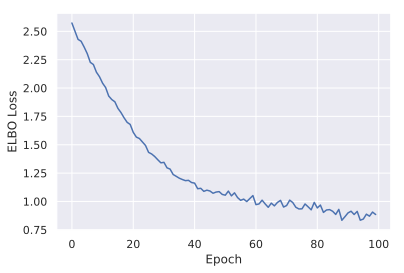

In [60]:
plt.plot(elbo1)
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.show()

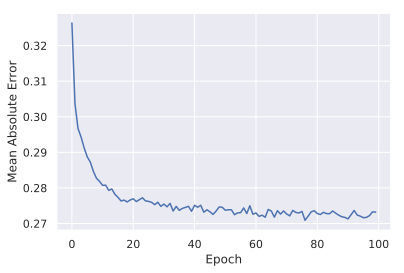

In [61]:
plt.plot(mae1)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.show()

TODO: does pretty well, almost as well as the keras net!

TODO: but there's one problem with that model: it assumes a constant error (the std dev param doesn't change depending on the input data). To fix that next we'll make a network which predicts both the mean and the std dev.

## Dual-headed Bayesian Density Network

TODO: a model which uses a net w/ 2 heads, one for mean and 1 for std

TODO: diagram

In [0]:
class BayesianDensityNetwork(tf.keras.Model):
    """Multilayer fully-connected Bayesian neural network, with two
    two heads to predict both the mean and the standard deviation.
    
    Parameters
    ----------
    input_dims : int
        Number of input dimensions
    units : list of int
        Number of output dimensions for each layer.
    name : None or str
        Name for the layer
    """
    
    
    def __init__(self, units, head_units, name=None):
        
        # Initialize
        super(BayesianDensityNetwork, self).__init__(name=name)
        
        # Create sub-networks
        self.core_net = BayesianDenseNetwork(units)
        self.loc_net = BayesianDenseNetwork([units[-1]]+head_units)
        self.std_net = BayesianDenseNetwork([units[-1]]+head_units)

    
    def call(self, x, sampling=True):
        """Pass data through the model
        
        Parameters
        ----------
        x : tf.Tensor
            Input data
        sampling : bool
            Whether to sample parameter values from their variational
            distributions (if True, the default), or just use the
            Maximum a Posteriori parameter value estimates (if False).
            
        Returns
        -------
        preds : tf.Tensor of shape (Nsamples, 2)
            Output of this model, the predictions.  First column is
            the mean predictions, and second column is the standard
            deviation predictions.
        """
        
        # Pass data through core network
        x = self.core_net(x, sampling=sampling)
        x = tf.nn.relu(x)
        
        # Make predictions with each head network
        loc_preds = self.loc_net(x, sampling=sampling)
        std_preds = self.std_net(x, sampling=sampling)
        std_preds = tf.nn.softplus(std_preds)
        
        # Return mean and std predictions
        return tf.concat([loc_preds, std_preds], 1)
    
    
    def log_likelihood(self, x, y, sampling=True):
        """Compute the log likelihood of y given x"""
        
        # Compute mean and std predictions
        preds = self.call(x, sampling=sampling)
        
        # Return log likelihood of true data given predictions
        return tfd.Normal(preds[:,0], preds[:,1]).log_prob(y[:,0])
        
        
    @tf.function
    def sample(self, x):
        """Draw one sample from the predictive distribution"""
        preds = self.call(x)
        samples[:,i] = tfd.Normal(preds[:,0], preds[:,1]).sample()
    
    
    def samples(self, x, n_samples=1):
        """Draw multiple samples from the predictive distribution"""
        samples = np.zeros((x.shape[0], n_samples))
        for i in range(n_samples):
            samples[:,i] = self.sample(x)
        return samples
        
        
    @property
    def losses(self):
        """The sum of the KL divergences between the priors and
        posteriors, assuming normal priors w/ mean=0 and std=1,
        for all layers.
        """
        return self.core_net.losses + self.loc_net.losses + self.std_net.losses

TODO: now can instantiate and fit the model

In [0]:
# Instantiate the model
model2 = BayesianDensityNetwork([8, 128, 64], [32, 16, 1])
# Note: [8 128 64], [32 16 1] net has 14728 weights (x2 = ~30k parameters)

TODO: we'll use the same optimizer + learning rate

In [0]:
# Use the Adam optimizer
optimizer = tf.keras.optimizers.Adam(lr=L_RATE)

In [0]:
N = x_train.shape[0]

@tf.function
def train_step(x_data, y_data):
    with tf.GradientTape() as tape:
        log_likelihoods = model2.log_likelihood(x_data, y_data)
        kl_loss = model2.losses
        elbo_loss = kl_loss/N - tf.reduce_mean(log_likelihoods)
    gradients = tape.gradient(elbo_loss, model2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model2.trainable_variables))
    return elbo_loss

In [0]:
# Fit the model
elbo2 = np.zeros(EPOCHS)
mae2 = np.zeros(EPOCHS)
for epoch in range(EPOCHS):
    
    # Update weights each batch
    for x_data, y_data in data_train:
        elbo2[epoch] = train_step(x_data, y_data)
        
    # Evaluate performance on validation data
    for x_data, y_data in data_val:
        y_pred = model2(x_data, sampling=False)[:, 0]
        mae2[epoch] = mean_absolute_error(y_pred, y_data)

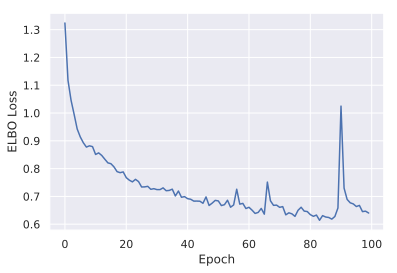

In [67]:
plt.plot(elbo2)
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.show()

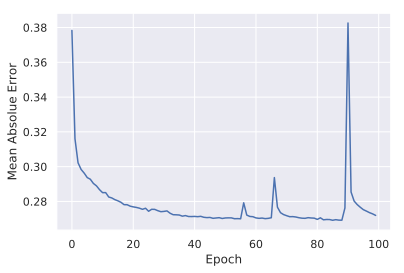

In [68]:
plt.plot(mae2)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolue Error')
plt.show()

TODO: plot MAE, ELBO over training

## Model Evaluation

TODO

### Learning Curves

TODO: two models do about the same in terms of their learning curves (MAE on val data):

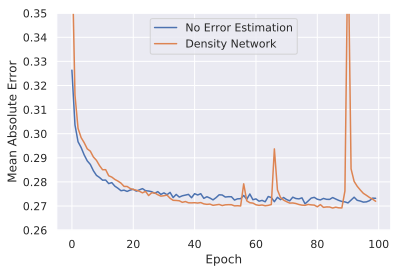

In [69]:
plt.plot(mae1, label='No Error Estimation')
plt.plot(mae2, label='Density Network')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.ylim([0.26, 0.35])
plt.show()

### Residuals

TODO

Text(0, 0.5, 'Count')

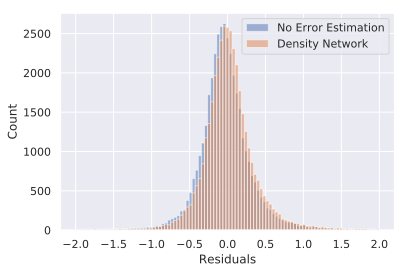

In [70]:
# Make predictions on validation data
for x_data, y_data in data_val:
    resids1 = y_data[:, 0] - model1(x_data, sampling=False)[:, 0]
    resids2 = y_data[:, 0] - model2(x_data, sampling=False)[:, 0]
    
# Plot residual distributions
bins = np.linspace(-2, 2, 100)
plt.hist(resids1.numpy(), bins, alpha=0.5,
         label='No Error Estimation')
plt.hist(resids2.numpy(), bins, alpha=0.5,
         label='Density Network')
plt.legend()
plt.xlabel('Residuals')
plt.ylabel('Count')

### Predictive Distributions

TODO

In [71]:
%%time

# Sample from predictive distributions
n_samples = 1000
for x_data, y_data in data_val:
    ix = np.random.choice(x_data.shape[0], 1000, replace=False)
    x_true = x_data.numpy()[ix, :]
    y_true = y_data.numpy()[ix, :]
    samples1 = model1.sample(x_true, n_samples=n_samples)
    samples2 = model2.sample(x_true, n_samples=n_samples)

TypeError: ignored

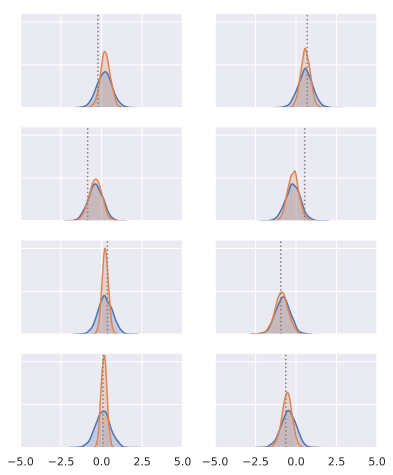

In [0]:
plt.figure(figsize=(6.4, 8))
for i in range(8):
    plt.subplot(4,2,i+1)
    sns.kdeplot(samples1[i,:], shade=True)
    sns.kdeplot(samples2[i,:], shade=True)
    plt.axvline(y_true[i], ls=':', color='gray')
    plt.xlim([-5, 5])
    plt.ylim([0, 2.2])
    plt.gca().get_yaxis().set_ticklabels([])
    if i<6:
        plt.gca().get_xaxis().set_ticklabels([])

### Coverage of the 95% Confidence Interval

TODO: look at coverage of the 95% interval

TODO: look at coverage of the 95% interval over some variable, ie time and space like below:

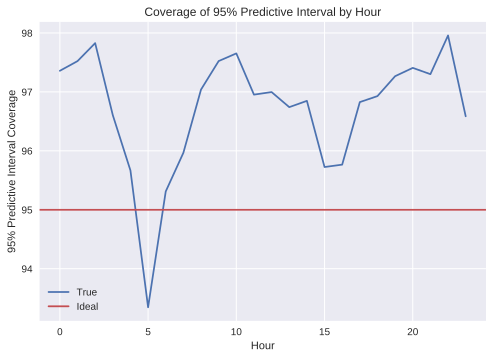

In [0]:
# Plot coverage as a fn of time of day
min_of_day = train_orig.loc[~tr_ind,'min_of_day'].values
covs = np.zeros(24)
for iT in range(0,24):
  ix = ((min_of_day>=(iT*60)) &
        (min_of_day<((iT+1)*60)))
  covs[iT] = coverage(prediction_dists[:,ix,0], y_val[ix])
plt.plot(covs, label='True')
plt.axhline(95.0, label='Ideal', color=colors[2])
plt.xlabel('Hour')
plt.ylabel('95% Predictive Interval Coverage')
plt.title('Coverage of 95% Predictive Interval by Hour')
plt.legend()
plt.show()

TODO: and we can also look at the coverage across pickup location

/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):
/usr/local/lib/python3.6/dist-packages/vaex/dataframe.py:1277: DeprecationWarning: Call to deprecated function iscategory: use is_category
  if self.iscategory(expression):


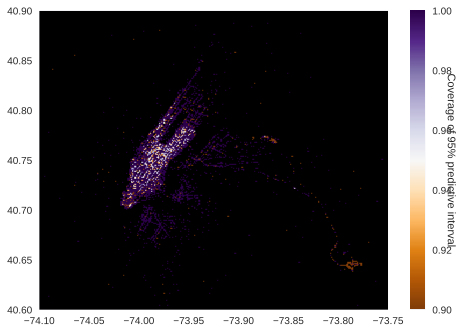

In [0]:
# Create vaex df with predictive intervals
cov_by_loc = pd.DataFrame()
cov_by_loc['x'] = train_orig.loc[~tr_ind,'pickup_longitude']
cov_by_loc['y'] = train_orig.loc[~tr_ind,'pickup_latitude']
cov_by_loc['covered'] = covered(prediction_dists[:,:,0], y_val)
vdf = vaex.from_pandas(cov_by_loc)

# Compute coverage of the predictive interval
lims = [[-74.1, -73.75],[40.6, 40.9]]
cov = vdf.mean(vdf.covered, limits=lims, shape=300,
               binby=[vdf.x,
                      vdf.y])

# Plot coverage of the predictive interval
cmap = matplotlib.cm.PuOr
cmap.set_bad('black', 1.)
plt.imshow(cov.T, origin='lower',
           vmin=0.9, vmax=1.0, cmap=cmap,
           extent=[lims[0][0], lims[0][1], 
                   lims[1][0], lims[1][1]])
ax = plt.gca()
ax.grid(False)
cbar = plt.colorbar()
cbar.set_label('Coverage of 95% predictive interval', 
               rotation=270)